### Non Personalized Recommendations
**Movielens 10 million dataset** is going to be used to build a recommender system. The dataset represents interactions between users and films.

In [1]:
import os
import zipfile

import pandas as pd
import numpy as np
import scipy.sparse as sps

import matplotlib.pyplot as plt
import seaborn as sns

from urllib.request import urlretrieve

### 1. Dowloading the Data

In [2]:
# If file exists, skip the download
data_dir = "datasets/Movielens10M/"
zip_data = data_dir + 'movielens_10m.zip'
zip_url = 'http://files.grouplens.org/datasets/movielens/ml-10m.zip'

# If directory does not exist, create
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

if not os.path.exists(zip_data):
    urlretrieve(zip_url, zip_data)

In [3]:
# extract rating data
# first, extract tags data
zip_path = 'datasets/Movielens10M/movielens_10m.zip'
file_name = 'ml-10M100K/ratings.dat'
target_dir = 'datasets/Movielens10M/decompressed'

zip_file = zipfile.ZipFile(zip_path)
file_path = zip_file.extract(file_name, path=target_dir)

In [4]:
df = pd.read_csv(
    file_path,
    sep='::',
    header=None,
    dtype={0:int, 1:int, 2:float, 3:int},
    engine='python'
)

df.columns = ['user_id', 'item_id', 'rating', 'timestamp']
df

,user_id,item_id,rating,timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392
3,1,292,5.0,838983421
4,1,316,5.0,838983392
...,...,...,...,...
10000049,71567,2107,1.0,912580553
10000050,71567,2126,2.0,912649143
10000051,71567,2294,5.0,912577968
10000052,71567,2338,2.0,912578016


In [5]:
print(f'The number of interactions is {df.shape[0]}')

The number of interactions is 10000054


### 2. EDA

**Basic statistics**

In [6]:
uu = df['user_id'].unique()
ui = df['item_id'].unique()

print('N Unique Users: ', uu.shape[0])
print('N Unique Items: ', ui.shape[0])
print('N Interactions: ', df.shape[0])

N Unique Users:  69878
N Unique Items:  10677
N Interactions:  10000054


**Important note**

If we check number of *unique users/unique items* and compare with the *max(user_id/item_id)* we will see that *n_uu < max(user_id)*. This is due to empty profile, let's reindex the DataFrame

In [23]:
# we have missing user_id and item_id
print('Missing user_id: ', uu[20:30])
print('Missing item_id: ', np.sort(ui)[89:100])

Missing user_id:  [24 26 27 28 29 30 33 34 35 36]
Missing item_id:  [ 90  92  93  94  95  96  97  98  99 100 101]


**pd.factorize()**

This is useful function for our recommendations. 

In [9]:
# examples
items = ['iPhone', 'Samsung', 'Nokia', 'iPhone', 'Samsung', 'Samsung']
indices, uniques = pd.factorize(items)

print('Indices: ', indices)
print('Unique Elements: ', uniques)

Indices:  [0 1 2 0 1 1]
Unique Elements:  ['iPhone' 'Samsung' 'Nokia']


In [24]:
# correct user_id and item_id
new_index, original_id = pd.factorize(uu) # returns unique elements and its indices
user_id_new = pd.Series(new_index, index=original_id) # use old user_id as index 

new_index, original_id = pd.factorize(ui)
item_id_new = pd.Series(new_index, index=original_id)

In [26]:
# got mapping (old_id : new_id)
display(user_id_new)
print()
display(item_id_new)

1            0
2            1
3            2
4            3
5            4
         ...  
71563    69873
71564    69874
71565    69875
71566    69876
71567    69877
Length: 69878, dtype: int64

122          0
185          1
231          2
292          3
316          4
         ...  
7537     10672
63481    10673
64652    10674
64427    10675
63662    10676
Length: 10677, dtype: int64

In [27]:
item_id = 292
print(f"New index for item {item_id} is {item_id_new[item_id]}")

New index for item 292 is 3


In [28]:
# apply reindexing 
df['user_id'] = df['user_id'].map(user_id_new)
df['item_id'] = df['item_id'].map(item_id_new)
df

,user_id,item_id,rating,timestamp
0,0,0,5.0,838985046
1,0,1,5.0,838983525
2,0,2,5.0,838983392
3,0,3,5.0,838983421
4,0,4,5.0,838983392
...,...,...,...,...
10000049,69877,518,1.0,912580553
10000050,69877,1660,2.0,912649143
10000051,69877,537,5.0,912577968
10000052,69877,541,2.0,912578016


In [29]:
uu = df['user_id'].unique()
ui = df['item_id'].unique()

n_uu = uu.shape[0]
n_ui = ui.shape[0]
n_interactions = df.shape[0]

print('N Unique Users: ', n_uu)
print('N Unique Items: ', n_ui)
print('N Interactions: ', n_interactions)

N Unique Users:  69878
N Unique Items:  10677
N Interactions:  10000054


In [30]:
max(df['user_id']), max(df['item_id'])

(69877, 10676)

**Now indices are correct**

In [32]:
user_avg_inter = n_interactions / n_uu
item_avg_inter = n_interactions / n_ui
sparsity = (1 - (n_interactions / (n_uu * n_ui)))*100 # 1 - n_inter / (n_uu * n_ui)

print("Average interactions per user {:.2f}".format(user_avg_inter))
print("Average interactions per item {:.2f}\n".format(item_avg_inter))
print("Sparsity {:.2f} %".format(sparsity))

Average interactions per user 143.11
Average interactions per item 936.60

Sparsity 98.66 %


**Rating Distribution in Time**

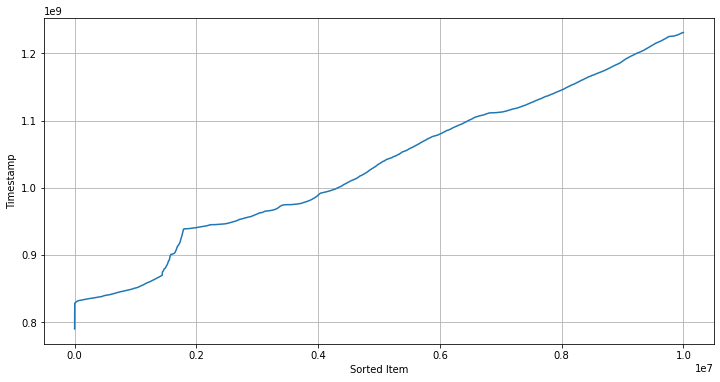

In [33]:
time_sorted = df['timestamp'].values.copy()
time_sorted.sort()

plt.figure(figsize=(12, 6))
plt.plot(time_sorted)
plt.xlabel('Sorted Item')
plt.ylabel('Timestamp')
plt.grid();

### 3. Sparse Matrix Creation
First, let's create a *coo matrix* and later change its format

In [34]:
# coo_matrix expects the following input format -> (data, (row, column))
coo_matrix = sps.coo_matrix(
    (df['rating'], (df['user_id'], df['item_id']))
)
coo_matrix

<69878x10677 sparse matrix of type '<class 'numpy.float64'>'
	with 10000054 stored elements in COOrdinate format>

Only now our matrix have the required format: `n_users * n_items`. 

Later depending on where in the matrix we want to apply calculations (rows/columns) we can easily transform the matrix into *csr/csc*

### 4. Item Popularity Calculation
Item popularity can be easily calculated using our sparse matrix. Simply need to sum columns (`column_i -> item_i`)

We say that the item is popular if it has many interactions (our heuristic). **The most popular item - item with max number of interactions**

**Important**

For fast and efficient calculation on columns it's better to use CSC sparse format (**items are in columns**)

In [35]:
# convert coo into csc
csc_matrix = coo_matrix.tocsc()
item_pop = np.ediff1d(csc_matrix.indptr)  # use np.ediff1d method to get the sum per item

# item popularity in descending order
item_pop = -np.sort(-item_pop)
item_pop

array([34864, 34457, 33668, ...,     1,     1,     1], dtype=int32)

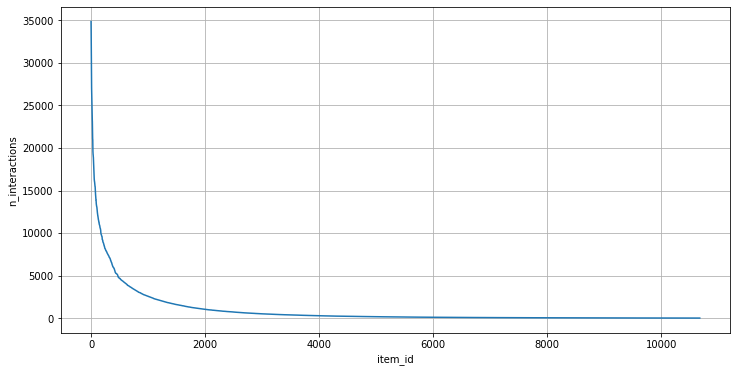

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(item_pop)
plt.xlabel('item_id')
plt.ylabel('n_interactions')
plt.grid();

We can see many items have not been seen/interecated by users

**Items statistics**

In [37]:
# select top n % popular items 
n = 10
top_n = int(n_ui/n)

In [38]:
print(f'AVG per-item interaction for the whole dataset: {round(item_pop.mean(), 3)}')
print(f'AVG per-item interaction for top {n}% popular items: {round(item_pop[:top_n].mean(), 2)}') 
print(f'AVG per-item interaction for the least {n}% popular items: {round(item_pop[-top_n:].mean(), 2)}')
print('N Items with zero interactions: ', np.sum((item_pop == 0)))

AVG per-item interaction for the whole dataset: 936.598
AVG per-item interaction for top 10% popular items: 6479.52
AVG per-item interaction for the least 10% popular items: 5.23
N Items with zero interactions:  0


### 5. User Profile Length
It's important to know which users are active and which not. 

Define the following heuristic: **active users an average will have more interactions than not active**

**Important**

For fast and efficient row calculations it's better to use `CSR format` (**users are in rows**)

In [39]:
csr_matrix = coo_matrix.tocsr()

# user profile calculation (user activity)
user_activity = np.ediff1d(csr_matrix.indptr) 
user_activity = -np.sort(-user_activity)

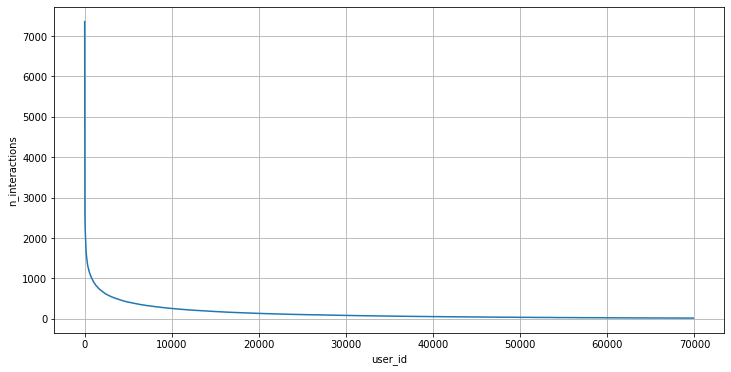

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(user_activity)
plt.xlabel('user_id')
plt.ylabel('n_interactions')
plt.grid();

### 6. Recommender System Evaluation
In order to evaluate any recommender we have to define:
- train and test data
- evaluation metric
- algorithm

In [41]:
train_mask = np.random.choice(
    [True, False],
    n_interactions,
    p=[0.8, 1 - 0.8]
)

test_mask = np.logical_not(train_mask)

display(train_mask)
display(test_mask)

array([ True,  True, False, ...,  True,  True,  True])

array([False, False,  True, ..., False, False, False])

To create train data efficiently we need to convert out `coo_matrix` into `csr_matrix` using data, row and col attributes of `coo_matrix` 

**train/test split**

In [42]:
train_data = sps.csr_matrix((
    # rating, user_id * item_id
    coo_matrix.data[train_mask], (
        coo_matrix.row[train_mask], coo_matrix.col[train_mask]
    ))
)
    
test_data = sps.csr_matrix((
    coo_matrix.data[test_mask], (
        coo_matrix.row[test_mask], coo_matrix.col[test_mask]
    ))
)

In [43]:
print('N Interactions (Train): ', train_data.nnz)
print('N Interactions (Test): ', test_data.nnz)

N Interactions (Train):  8002897
N Interactions (Test):  1997157


All items in the test data are **called relevant**

In [59]:
user_id = 124
user_row_values = test_data[user_id] # get row for the user
print('User Row in Test Data: ', user_row_values.toarray()[0][:20]) # only first 20 values
print()

# to get items with which a user did interact, we use indices attribute
relevant_u_items = test_data[user_id].indices
print('Interacted Items Indices:')
relevant_u_items

User Row in Test Data:  [0. 0. 0. 0. 0. 0. 0. 0. 4. 0. 0. 0. 0. 0. 5. 0. 0. 0. 0. 0.]

Interacted Items Indices:


array([   8,   14,   75,   79,   88,  145,  146,  150,  165,  181,  183,
        220,  235,  236,  327,  394,  403,  423,  425, 1077, 1283, 1314,
       1466, 1622, 2492, 2578, 2771])

In [60]:
# let's look at that user 
user_df = df[df['user_id'] == user_id]
user_df

,user_id,item_id,rating,timestamp
14984,124,96,4.0,868266170
14985,124,302,3.0,868266445
14986,124,1280,4.0,868266445
14987,124,71,5.0,868266486
14988,124,101,4.0,868266169
...,...,...,...,...
15106,124,1469,3.0,868266827
15107,124,241,3.0,868267110
15108,124,183,3.0,868267215
15109,124,47,5.0,868266740


In [61]:
# let's look at all items with which the user interacted
user_items = user_df['item_id'].unique()
print('All Interacted Items for a User:')
user_items

All Interacted Items for a User:


array([  96,  302, 1280,   71,  101, 1558, 1283,   22,  312,   74,   75,
         77,   79,   24,  327, 1008,    4,    5,   83,  336,    8,    9,
         11,  340,   85,   88,  175,   14, 2092, 2555,  137,  358,   18,
         19,   93,  139,   20,   94, 1427,  360,   27, 1429, 1601,   29,
         30, 1603, 1496,   31, 1302, 1303, 1304,  373,   34,  144,  218,
        219,  145,  220,  146,  148, 1122, 2310,  150,  382,   36,  225,
       1310,  156,  394,  398,  399,  177,  178,  179,  401, 1458,  162,
        403,   37, 1021,  404,  406,  165, 1312,  166,  407,  227,  228,
        170, 1127, 1314,   44,  408,  231, 1316,  410,  234, 2492,  235,
        413,   45,  181, 1464, 1466,  236,  237,  415, 1468, 1318, 2771,
        418,  238,   38,  423, 2578, 1622,  424, 1077, 1078, 1079,  425,
       1321, 1469,  241,  183,   47, 1474], dtype=int64)

In [65]:
assert len(relevant_u_items) == len(set(relevant_u_items).intersection(set(user_items)))

Perfect, items for that particular user are the same as in test data 

**recommendation example**

let's say that we already trained an algorithm and got the recommendation of n elements for a particular user

In [69]:
recommended_items = np.array([777, 22, 15, 111, 211])
recommended_items

array([777,  22,  15, 111, 211])

In [70]:
is_relevant = np.in1d(recommended_items, relevant_u_items, assume_unique=True)
is_relevant

array([False, False, False, False, False])

None of recommended items are relevant

### 7. Evaluation Metrics (Precision, Recall, AvgPrecision)
It's similar to classification task
- **Precision@K:** how many of recommended items are relevant
- **Recall@K:** how many of relevant items we recommended
- **AvgPrecision:** 

Usually we recommend n items -> that's why we use @K in the metrics

In [57]:
def precision(recommended_i, relevant_i):
    is_relevant = np.in1d(recommended_i, relevant_i, assume_unique=True)
    score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)
    return score


def recall(recommended_i, relevant_i):
    is_relevant = np.in1d(recommended_i, relevant_i, assume_unique=True)
    score = np.sum(is_relevant, dtype=np.float32) / relevant_i.shape[0]
    return score


def avg_precision(recommended_i, relevant_i):
    is_relevant = np.in1d(recommended_i, relevant_i, assume_unique=True)
    # cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))
    score = np.sum(p_at_k) / np.min([relevant_i.shape[0], is_relevant.shape[0]])
    return score

In [58]:
print('Precision: ', precision(recommended_items, relevant_u_items))
print('Recall: ', precision(recommended_items, relevant_u_items))
print('AVG Precision: ', avg_precision(recommended_items, relevant_u_items))

Precision:  0.0
Recall:  0.0
AVG Precision:  0.0


Our current recommendation is awful (but we know it)

### 8. Basic Recommenders

**Random Recommender**

With such model we don't have to learn anything from the data

In [59]:
class RandomRecommender():
    """
    RecSys that randomly recommends items 
    """
    
    def fit(self, data):
        self.n_items = data.shape[1]
        
        
    def recommend(self, user_id, at=5):
        recommended_items = np.random.choice(self.n_items, at)
        return recommended_items

In [61]:
random_recommender = RandomRecommender()
random_recommender.fit(train_data)

# predict for 5 users 10 items
for user_id in range(5):
    print(random_recommender.recommend(user_id, at=5))

[ 6320  2439 10661  1975  1528]
[ 7787  9030 10329  2477  4458]
[5556 9392 1466 8528 9609]
[ 768 9614 5052 3521 5600]
[10178  8596  5131  9931 10631]


**Model evaluation**

In [174]:
def evaluate_model(test_data, model, at=5, return_scores=True):
    cum_precision = 0
    cum_recall = 0
    cum_avg_precision = 0
    n_eval = 0
    
    for user_id in range(test_data.shape[0]):
        relevant_items = test_data.indices[
            test_data.indptr[user_id]:test_data.indptr[user_id + 1]
        ]
        if len(relevant_items) > 0:
            recommended_items = model.recommend(user_id, at=at)
            n_eval += 1
            
            cum_precision += precision(recommended_items, relevant_items)
            cum_recall += recall(recommended_items, relevant_items)
            cum_avg_precision += avg_precision(recommended_items, relevant_items)
        
    cum_precision /= n_eval
    cum_recall /= n_eval
    MAP = cum_avg_precision / n_eval
    print('Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}'.format(
        cum_precision, cum_recall, MAP
    ))
    if return_scores:
        scores = [round(score, 5) for score in [cum_precision, cum_recall, MAP]]
        return scores

In [175]:
# create dict with metrics results for later model comparison
model_results = {}
model_results['rando_rec'] = evaluate_model(test_data, random_recommender)

Precision = 0.0028, Recall = 0.0005, MAP = 0.0013


The recommended works but the quality is awful. The model is uselss but the main idea was to get an idea and practice!

**Top Popular Recommender**

- Let's recommend the most popular items to all users 

In [177]:
class TopPopRecommender():
    """
    RecSys that recommends only popular items
    """
    def fit(self, train_data):
        item_popularity = np.ediff1d(train_data.tocsc().indptr)
        pop_items = np.argsort(item_popularity)
        self.pop_items = np.flip(pop_items, axis=0)
    
    
    def recommend(self, user_id, at=5):
        recommended_items = self.pop_items[:at]
        return recommended_items

In [178]:
top_pop_recommender = TopPopRecommender()
top_pop_recommender.fit(train_data)

# predict for 5 users 5 items
for user_id in range(5):
    print(top_pop_recommender.recommend(user_id, at=5))

[1008    7  139   14 1293]
[1008    7  139   14 1293]
[1008    7  139   14 1293]
[1008    7  139   14 1293]
[1008    7  139   14 1293]


In [179]:
model_results['top_pop_rec'] = evaluate_model(test_data, top_pop_recommender)

Precision = 0.0958, Recall = 0.0309, MAP = 0.0531


Quality improved! but we can improve the `top_pop_recommender`

**Top Popular Recommender (Seen Removed)**

- **Idea:** let's remove items than already been seen by users

In [180]:
class TopPopRecommender():
    """
    RecSys that recommends popular items that have not yet been seen by a user 
    
    """
    def fit(self, train_data):
        item_popularity = np.ediff1d(train_data.tocsc().indptr)
        pop_items = np.argsort(item_popularity)
        self.pop_items = np.flip(pop_items, axis=0)
        self.train_data = train_data
    
    
    def recommend(self, user_id, at=5, remove_seen=True):
        if remove_seen:
            seen_items = self.train_data.indices[
                self.train_data.indptr[user_id]:self.train_data.indptr[user_id + 1]
            ]
            unseen_items_mask = np.in1d(self.pop_items, seen_items, assume_unique=True, invert=True)
            unseen_items = self.pop_items[unseen_items_mask]
            recommended_items = unseen_items[:at]
        else:
            recommended_items = self.pop_items[:at]
        return recommended_items

In [182]:
top_pop_recommender = TopPopRecommender()
top_pop_recommender.fit(train_data)

# predict for 5 users 5 items
for user_id in range(5):
    print(top_pop_recommender.recommend(user_id, at=5, remove_seen=True))

[1008  139 1293   22   19]
[1008    7  139   14 1293]
[1008    7  139   14 1293]
[1008    7  139 1293   19]
[1008    7  139   14 1293]


We see that if a popular item has already been seen by a user it's substituted by another popular item that have not been seen yet

In [183]:
model_results['top_pop_rec_unseen'] = evaluate_model(test_data, top_pop_recommender)

Precision = 0.1987, Recall = 0.0530, MAP = 0.1474


The qulity improved drastically (**always remove seen items if the purpose is to recommend "new ones"**)

**Top Rated Recommender**

- Let's recommend only the highest rated items

In [184]:
# first, calculate mean of all ratings (global mean)
print('Ratings array: ', train_data.data)
gloabl_mean_rating = np.mean(train_data.data)
print('The global avg rating: {:.2f}'.format(gloabl_mean_rating))

Ratings array:  [5. 5. 5. ... 3. 1. 1.]
The global avg rating: 3.51


Since we have users and items we can calculate mean rating on *user-level* or *item-level*
- `user_mean_rating`: how on average a user rate a film (low mean - critic, high mean - film lovers)
- `item_mean_rating`: how good/interesting a film across all users (low mean - boring/awful, high mean - interesting)
- `global_mean_rating`: mean of all ratings (array of ratings is flatten and mean is calculated)

In [185]:
ratings_dist = pd.Series(train_data.data).value_counts()
ratings_dist

4.0    2301801
3.0    1885316
5.0    1234832
3.5     703813
2.0     632606
4.5     468329
1.0     307610
2.5     296254
1.5      94813
0.5      76272
dtype: int64

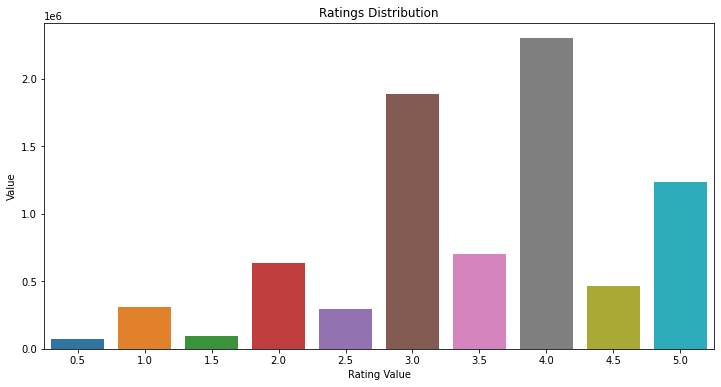

In [186]:
plt.figure(figsize=(12,6))
sns.barplot(x=ratings_dist.index, y=ratings_dist.values);
plt.title('Ratings Distribution')
plt.xlabel('Rating Value')
plt.ylabel('Value');

Most of the time films are rated between 3 and 4

In [187]:
# substract the bias from all ratings
train_data_unbiased = train_data.copy()
train_data_unbiased.data -= gloabl_mean_rating

print('Unbiased Ratings')
train_data_unbiased.data[:10]

Unbiased Ratings


array([1.48797879, 1.48797879, 1.48797879, 1.48797879, 1.48797879,
       1.48797879, 1.48797879, 1.48797879, 1.48797879, 1.48797879])

**ItemBias Calculation**

Calculate unbiased rating for each item or so-called *ItemBias*

We cannot use the mean function because it would include also the zero values, which we want to exclude since they mean "missing data"

**The mean should be computed only on existing ratings.** To avoid attributing high rating values to items rated by only a few users we can add a constant term to the denominator in order to penalize items with very few ratings.

In [188]:
lambda_item = 25 # penalization value for item

n_nnz_col = np.ediff1d(sps.csc_matrix(train_data_unbiased).indptr)
print('N NNZ in Each Column (N Non-Zero Ratings for Each Item):')
display(n_nnz_col)

# now we need to compute the mean rating for each item excluding the missing values (otherwise it will be biased)
item_mean_rating = train_data_unbiased.sum(axis=0) / (n_nnz_col + lambda_item) # get sum rating for each column and divide by n_nnz_col
item_mean_rating = np.asarray(item_mean_rating).ravel()  # converts 2-d matrix to 1-d array 
item_mean_rating[col_nnz == 0] = -np.inf

item_mean_rating = np.array(item_mean_rating).squeeze()
item_mean_rating = np.sort(item_mean_rating[item_mean_rating != 0])

print('\nMean Unbiased Item Rating:')
display(item_mean_rating)

N NNZ in Each Column (N Non-Zero Ratings for Each Item):


array([ 1931, 11931, 14307, ...,     1,     1,     1], dtype=int32)


Mean Unbiased Item Rating:


array([      -inf,       -inf,       -inf, ..., 0.85490831, 0.90187153,
       0.94191735])

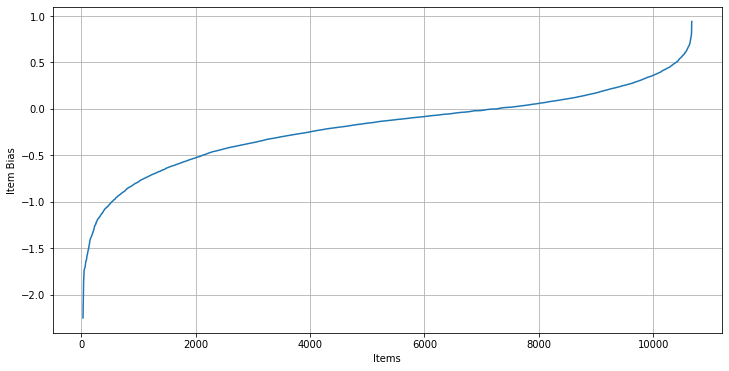

In [189]:
plt.figure(figsize=(12, 6))
plt.plot(item_mean_rating)
plt.xlabel('Items')
plt.ylabel('Item Bias')
plt.grid();

**UserBias Calculation**

Calculate ubiased mean rating for each user

In [190]:
lambda_user = 10

n_nnz_row = np.ediff1d(train_data_unbiased.indptr)
print('Rating Sum for Each User: ', n_nnz_row)

# UserBias calculation
user_mean_rating = train_data_unbiased.sum(axis=1).ravel() / (n_nnz_row + lambda_user)
user_mean_rating = np.asarray(user_mean_rating).ravel()
user_mean_rating[row_nnz == 0] = -np.inf

user_mean_rating = np.array(user_mean_rating).squeeze()
user_mean_rating = np.sort(user_mean_rating[user_mean_rating != 0.0])

print('\nMean Unbiased User Rating:')
display(user_mean_rating)

Rating Sum for Each User:  [ 18  17  26 ... 113  39  42]

Mean Unbiased User Rating:


array([-2.38623391, -2.30611784, -2.15593138, ...,  1.30582939,
        1.30870423,  1.34979798])

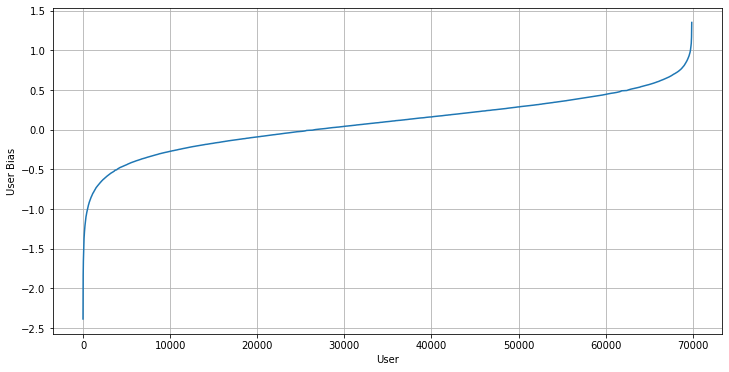

In [191]:
plt.figure(figsize=(12, 6))
plt.plot(user_mean_rating)
plt.xlabel('User')
plt.ylabel('User Bias')
plt.grid();

Now items can be sorted according to their `ItemBias` and we can use the same approach as for `TopPop recommendatins`

In [192]:
class TopRatedRecommender():
    """
    RecSys that recommends most rated items that have not yet been seen by a user 
    """
    def fit(self, train_data, lambda_user=10, lambda_item=25):
        self.data = train_data
        self.mu = self.data.data.sum(dtype=np.float32) / self.data.nnz # global mean getting 
        n_nnz_col = np.ediff1d(sps.csc_matrix(self.data).indptr) # n non-zero elements for each column 
        
        data_unbiased = self.data.copy()
        data_unbiased.data -= self.mu
        
        item_bias = data_unbiased.sum(axis=0) / (n_nnz_col + lambda_item)
        item_bias = np.asarray(item_bias).ravel()
        item_bias[col_nnz == 0] = -np.inf
        
        best_rated_items = np.argsort(item_bias)
        self.best_rated_items = np.flip(best_rated_items, axis=0)
        
    
    def recommend(self, user_id, at=5, remove_seen=True):
        if remove_seen:
            seen_items = self.data.indices[
                self.data.indptr[user_id]:self.data.indptr[user_id + 1]
            ]
            unseen_items_mask = np.in1d(self.best_rated_items, seen_items, assume_unique=True, invert=True)
            unseen_items = self.best_rated_items[unseen_items_mask]
            recommended_items = unseen_items[:at]
        else:
            recommended_items = self.best_rated_items[:at]
        return recommended_items        

In [194]:
top_rated_recommender = TopRatedRecommender()
top_rated_recommender.fit(train_data)

# predict for 5 users 5 items
for user_id in range(5):
    # recommend from top rated items
    print(top_rated_recommender.recommend(user_id, at=5, remove_seen=True))

[1293   34  213  133 1441]
[1293   34  213  133 1441]
[1293   34  213  133 1441]
[1293   34  213  133 1441]
[1293  213 1441  145  218]


In [195]:
model_results['top_rated_rec_unseen'] = evaluate_model(test_data, top_rated_recommender)

Precision = 0.0767, Recall = 0.0190, MAP = 0.0546


`GlobalEffectsRecommender` has worse performance though we use "more information".

In [196]:
# let's see how TopPopRecommender acuracy changes by using only highly rated items to calculate the popularity
for rating_threshold in range(0, 5):
    print(f'Removing ratings <= {rating_threshold}')
    train_filtered = train_data.copy()
    train_filtered.data[train_filtered.data <= rating_threshold] = 0
    train_filtered.eliminate_zeros()
    
    top_pop_recommender = TopPopRecommender()
    top_pop_recommender.fit(train_filtered)
    evaluate_model(test_data, top_pop_recommender)

Removing ratings <= 0
Precision = 0.1987, Recall = 0.0530, MAP = 0.1474
Removing ratings <= 1
Precision = 0.1956, Recall = 0.0528, MAP = 0.1439
Removing ratings <= 2
Precision = 0.1883, Recall = 0.0512, MAP = 0.1362
Removing ratings <= 3
Precision = 0.1621, Recall = 0.0438, MAP = 0.1083
Removing ratings <= 4
Precision = 0.1217, Recall = 0.0348, MAP = 0.0742


**Questions**
- Why is `TopRatedRecommender` performing worse than `TopPopRecommender` even if we are taking into account "more information" about the interaction?
- Why `TopPopRecommender` getting worse if we remove interactions with low rating items?

**Answer**

Sometimes **ratings are not really more informative than interactions.** 

Most of the users tend to leave implicit feedback (don't leave any ratings), thus implicit feedback (in our case - items interaction is more reliable)